In [159]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [160]:
project_name='05-cifar10-cnn'

In [161]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [162]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

data_dir = './data/cifar10'

In [163]:
## Data tronsform (normalization and data augmentation)

import torchvision.transforms as tt

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'), 
                                    tt.RandomHorizontalFlip(),
#                                    tt.RandomRotate,
#                                    tt.RandomResizedCrop(256, scale = (0.5, 0.9), ratio = (1,1)),
#                                    tt.Colorjitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
                                   tt.ToTensor(),
                                   tt.Normalize(*stats)
                                   ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


In [164]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
train_ds = ImageFolder(data_dir+'/train', transform=train_tfms)
valid_ds = ImageFolder(data_dir+'/test', transform = valid_tfms)


In [165]:
# Converting data into batches for training and validation
from torch.utils.data import DataLoader
batch_size = 100
train_loader = DataLoader(train_ds,batch_size, shuffle = True, num_workers = 3, pin_memory = True)
# Shuffle set to true to get different batch of data every epoch
val_loader = DataLoader(valid_ds, batch_size, num_workers = 3, pin_memory = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


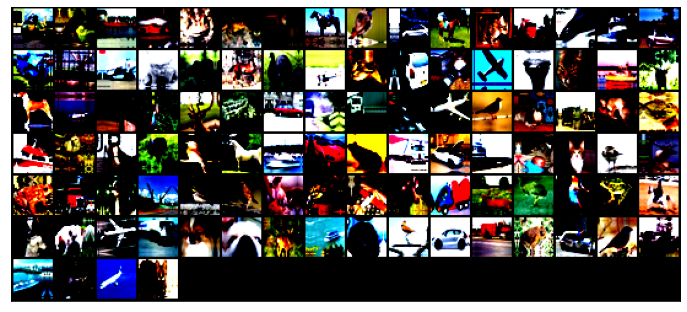

In [166]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

dl = train_loader
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(dl)


In [167]:


# # Defining model 
# import torch.nn as nn

# model = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # 3 = number of input channels and 32 = no. of output channels
#     nn.ReLU(),
#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

#     nn.Flatten(), 
#     nn.Linear(128*8*8, 10),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
#     nn.Linear(64*16*16, 10))

# for i in model.parameters():
#     print(i)

In [168]:
# import torch.nn as nn
# model1 = nn.Conv2d(3,32, kernel_size =3, stride=1, padding=1)
# model2 = nn.Conv2d(32,64,kernel_size =3, stride=1, padding=1)
# model3 = nn.Sequential(nn.Conv2d(3,32, kernel_size =3, stride=1, padding=1), 
#                        nn.ReLU(),nn.Conv2d(32,64,kernel_size =3, stride=1, padding=1),nn.ReLU(), nn.MaxPool2d(2,2))
# # 16 x 16 x 64
# model4 = nn.Conv2d(64, 128, kernel_size =3, stride=1, padding=1)
# model5 = nn.Conv2d(64, 256, kernel_size =3, stride=1, padding=1)
# model6 = nn.Sequential(nn.Conv2d(64, 128, kernel_size =3, stride=1, padding=1), nn.ReLU(),
#                       nn.Conv2d(64, 256, kernel_size =3, stride=1, padding=1), nn.ReLU(),
#                       nn.MaxPool2d(2,2))
# # 4 x 4 x 256
# model7 = nn.Sequential(nn.Flatten(), nn.Linear(4*4*256, 10))

In [169]:
import torch

class Cresidualnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size =3, stride=1, padding=1) # out - 32 x 32 x 32
        self.conv2 = nn.Conv2d(32,64,kernel_size =3, stride=1, padding=1) # out - 64 x 32 x 32 
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size =3, stride=1, padding=1), 
                       nn.ReLU(),nn.Conv2d(64,64,kernel_size =3, stride=1, padding=1),nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Conv2d(64, 128, kernel_size =3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size =3, stride=1, padding=1)
        self.res2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size =3, stride=1, padding=1), nn.ReLU(),
                      nn.Conv2d(256, 256, kernel_size =3, stride=1, padding=1), nn.ReLU(),
                      nn.MaxPool2d(2,2))
        self.linear =  nn.Sequential(nn.Flatten(), nn.Dropout(0.2), nn.Linear(8*8*256, 10)) # Dropout is introduced
    
    def forward(self,xb):
        out = self.conv1(xb) # out - 32 x 32 x 32
        r = nn.ReLU()
        out = r(out)
        out = self.conv2(out) # out - 64 x 32 x 32
        out = r(out)
        m = nn.MaxPool2d(2,2) # out - 64 x 16 x 16
        out = self.res1(out) + m(out) # out - 64 x 16 x 16
        out = self.conv3(out) # out - 128 x 16 x 16
        out = r(out)
        out = self.conv4(out) # out - 256 x 16 x 16
        out = r(out)
        m = nn.MaxPool2d(2,2) # out - 256 x 8 x 8
        out = self.res2(out) + m(out)  # out - 256 x 8 x 8
        out = self.linear(out) 
        return out

model = Cresidualnet()



In [2]:
import torch
loss_fn = torch.nn.functional.cross_entropy
epochs = 8
lr = 0.05
grad_clip = 0.1
weight_decay = 1e-4

opt_func = torch.optim.Adam

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']
    
def fit(epochs):
    
    lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4

  
    for epoch in range(epochs):
        
        a = []
        i = 0
        # can set beta1, beta 2 and epslon and weight decay which is lambda of l2 reguralization
        lr = lr/(1+(epoch+1)) 
        print('learning rate : ', lr, end = '')
        optimizer = opt_func(parameters, lr, weight_decay = weight_decay)
        model.train()
        for batch in train_loader:
            
            image, labels = batch
            out = model.forward(image)
            loss = loss_fn(out, labels)
            loss.backward()
            
            # Gradient clipping
            
            nn.utils.clip_grad_value_(parameters, grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            

            
        
        model.eval()
        
        for batch in val_loader:
            image, labels = batch
            out = model.forward(image)
            _,pred = torch.max(out,1)
            acc = (torch.sum(pred==labels)/len(labels))
            a.append(acc)
            i+=1  
        print('  Accuracy : ',sum(a)/i)


  

Object `nn.utils.clip_grad_value_` not found.


In [171]:
fit(1)

learning rate :  0.005  Accuracy :  tensor(0.1059)
